# Explore PostGIS Databases with Python

- See this tutorial:
    - [How to build a Postgis geodabatase with Python and Geoalchemy](https://hatarilabs.com/ih-en/how-to-build-a-postgis-geodabatase-with-python-and-geoalchemy-with-connexion-to-qgis3-tutorial);  
- Learning more about geoparquet files;

## Initial Setup

### Imports

In [1]:
# Load packages.
import os
import ee
import sys
import geemap

import pandas as pd
import geopandas as gpd

from shapely.geometry import Point
from geoalchemy2 import Geometry

# Geosatlearn library to import.
lib_path = "/geosatlearn_app"
if lib_path not in sys.path:
    sys.path.append(lib_path)

from geosatlearn import create_flask_app

%matplotlib inline

### Google Earth Engine Authentication

In [2]:
EARTHENGINE_TOKEN = os.environ.get("EARTHENGINE_TOKEN")
ee.Authenticate()
ee.Initialize()

### Database Instance

In [3]:
FLASK_APP = create_flask_app()
DATABASE = FLASK_APP.extensions["sqlalchemy"]

with FLASK_APP.app_context():
    print(DATABASE.engine)

Engine(postgresql://postgres:***@db_service:5432/geosatlearn_database)


## Well Stations

### Analyze Data

In [4]:
# Open a csv file as a pandas dataframe object.
df_wells = pd.read_csv("/geosatlearn_app/data/well_stations.csv", index_col=0, parse_dates=[4, 6])
df_wells

,STATION_NM,dec_lat_va,dec_long_v,DTdeparsed,WLA_DEM,Date
0,JL-49-13-509,31.815556,-106.434167,1913-07-27,3686.72,1913-07-27
1,JL-49-13-521,31.826944,-106.425000,1915-10-20,3688.98,1915-10-20
2,JL-49-13-816,31.788611,-106.453334,1919-05-19,3673.88,1919-05-19
3,JL-49-13-523,31.826944,-106.422778,1920-01-06,3660.38,1920-01-06
4,20N.08E.15.134,35.966111,-106.086667,1921-05-03,5571.08,1921-05-03
...,...,...,...,...,...,...
6162,WL-0024,34.057914,-106.918550,2017-02-27,4585.77,2017-02-27
6163,SO-0225,33.723322,-106.914567,2017-05-02,4480.20,2017-05-02
6164,SO-0275,34.002218,-106.856168,2017-05-05,4579.83,2017-05-05
6165,SO-0273,34.001896,-106.855393,2017-05-05,4579.71,2017-05-05


In [5]:
# Create a geodataframe. 
geometries_list = []
for index, row in df_wells.iterrows():
    row_lat = row.dec_lat_va
    row_lon = row.dec_long_v
    point = Point(row_lon, row_lat)
    geometries_list.append(point)

# Do it.
gdf_wells = gpd.GeoDataFrame(
    data={
        "STATION_NM": df_wells.STATION_NM,
        "DTdeparsed": df_wells.DTdeparsed,
        "WLA_DEM": df_wells.WLA_DEM,
        "Date": df_wells.Date, 
        "geometry": geometries_list
    },
    crs="EPSG:4269"
)

# Show it.
gdf_wells

,STATION_NM,DTdeparsed,WLA_DEM,Date,geometry
0,JL-49-13-509,1913-07-27,3686.72,1913-07-27,POINT (-106.43417 31.81556)
1,JL-49-13-521,1915-10-20,3688.98,1915-10-20,POINT (-106.425 31.82694)
2,JL-49-13-816,1919-05-19,3673.88,1919-05-19,POINT (-106.45333 31.78861)
3,JL-49-13-523,1920-01-06,3660.38,1920-01-06,POINT (-106.42278 31.82694)
4,20N.08E.15.134,1921-05-03,5571.08,1921-05-03,POINT (-106.08667 35.96611)
...,...,...,...,...,...
6162,WL-0024,2017-02-27,4585.77,2017-02-27,POINT (-106.91855 34.05791)
6163,SO-0225,2017-05-02,4480.20,2017-05-02,POINT (-106.91457 33.72332)
6164,SO-0275,2017-05-05,4579.83,2017-05-05,POINT (-106.85617 34.00222)
6165,SO-0273,2017-05-05,4579.71,2017-05-05,POINT (-106.85539 34.0019)


In [6]:
%%time

feature_collection_wells = geemap.geopandas_to_ee(
    gdf=gdf_wells,
    geodesic=True
)

CPU times: user 715 ms, sys: 36.5 ms, total: 752 ms
Wall time: 753 ms


In [7]:
# Visualize data.
Map = geemap.Map()
Map.addLayer(feature_collection_wells)
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Define Database Model

In [8]:
# Define table.
class StationWell(DATABASE.Model):
    
    __tablename__ = "station_well"

    # Columns of table.
    id = DATABASE.Column(DATABASE.Integer, primary_key=True)
    station = DATABASE.Column(DATABASE.String)
    lat = DATABASE.Column(DATABASE.Float)
    lon = DATABASE.Column(DATABASE.Float)
    date = DATABASE.Column(DATABASE.DateTime)
    geometry = DATABASE.Column(Geometry(geometry_type="POINT", srid="4269"))

### Create a Groundwater Well Database

In [9]:
%%time

with FLASK_APP.app_context():

    # (Re)create tables
    DATABASE.drop_all()
    DATABASE.create_all()
    DATABASE.session.commit()
    
    # Iterate over the dataframe to add well objects to the database session.
    for index, row in df_wells.iterrows():
        row_lat = row.dec_lat_va
        row_lon = row.dec_long_v
        
        well = StationWell(
            id=index,
            station=row.STATION_NM,
            lat=row_lat,
            lon=row_lon,
            date=row.Date,
            geometry="SRID=4269;POINT(%.8f %.8f)"%(row_lon, row_lat)
        )
        DATABASE.session.add(well)

    # Save changes on the session
    DATABASE.session.commit()

CPU times: user 1.32 s, sys: 15.8 ms, total: 1.34 s
Wall time: 1.9 s


## Brazilian States 

### Read Shape File Data

In [10]:
%%time

gdf_brazil = gpd.read_file(
    filename="/geosatlearn_app/data/BR_UF_2022.shp"
)

# Show it.
gdf_brazil

CPU times: user 86.4 ms, sys: 28 ms, total: 114 ms
Wall time: 129 ms


,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,AREA_KM2,geometry
0,12,Acre,AC,Norte,164173.429,"POLYGON ((-68.79282 -10.99957, -68.79367 -10.9..."
1,13,Amazonas,AM,Norte,1559255.881,"POLYGON ((-56.76292 -3.23221, -56.76789 -3.242..."
2,15,Pará,PA,Norte,1245870.704,"MULTIPOLYGON (((-48.97548 -0.19834, -48.97487 ..."
3,16,Amapá,AP,Norte,142470.762,"MULTIPOLYGON (((-51.04561 -0.05088, -51.05422 ..."
4,17,Tocantins,TO,Norte,277423.627,"POLYGON ((-48.2483 -13.19239, -48.24844 -13.19..."
5,21,Maranhão,MA,Nordeste\n,329651.496,"MULTIPOLYGON (((-44.5868 -2.23341, -44.58696 -..."
6,22,Piauí,PI,Nordeste\n,251755.481,"POLYGON ((-42.47034 -3.48377, -42.46126 -3.484..."
7,23,Ceará,CE,Nordeste\n,148894.447,"POLYGON ((-37.87162 -4.3664, -37.87109 -4.3670..."
8,24,Rio Grande do Norte,RN,Nordeste\n,52809.599,"MULTIPOLYGON (((-35.18728 -5.78987, -35.18707 ..."
9,25,Paraíba,PB,Nordeste\n,56467.242,"MULTIPOLYGON (((-34.7958 -7.175, -34.79578 -7...."


In [11]:
gdf_brazil.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Visualize Data

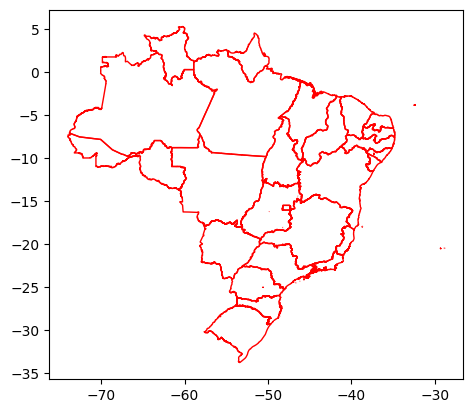

In [12]:
_ = gdf_brazil.plot(edgecolor="red", facecolor="none");

### Create Data Model

In [13]:
%%time

with FLASK_APP.app_context():

    gdf_brazil.to_postgis(
        name="brazil_ufs",
        con=DATABASE.engine,
        if_exists="replace",
        index=True
    )

CPU times: user 2.28 s, sys: 184 ms, total: 2.46 s
Wall time: 3.85 s
